# **Speech** **Emotion** **Recognition**

**Library**

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
import wave

**Preprocessing**

In [ ]:
from google.colab import drive


In [ ]:
RAV = "/content/drive/MyDrive/archive/"

In [ ]:
print(RAV)

/content/drive/MyDrive/archive/


In [ ]:
dir_list = os.listdir(RAV)


In [ ]:
emotion = []
gender = []
path = []
feature = []

In [ ]:
RAV

'/content/drive/MyDrive/archive/'

In [ ]:
for i in dir_list:
    fname = os.listdir(RAV + i)

for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[4])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender'], axis=1)
RAV_df.labels.value_counts()

labels
male_neutral       144
female_neutral     144
male_sad            98
male_happy          96
female_fear         96
female_happy        96
male_fear           96
male_angry          96
male_disgust        96
female_angry        96
female_sad          96
female_disgust      96
male_surprise       96
female_surprise     96
Name: count, dtype: int64

In [ ]:
display(RAV_df.head())
display(RAV_df.describe())

,emotion,labels,source,path
0,happy,male_happy,RAVDESS,/content/drive/MyDrive/archive/Actor_17/03-01-...
1,neutral,male_neutral,RAVDESS,/content/drive/MyDrive/archive/Actor_17/03-01-...
2,neutral,male_neutral,RAVDESS,/content/drive/MyDrive/archive/Actor_17/03-01-...
3,neutral,male_neutral,RAVDESS,/content/drive/MyDrive/archive/Actor_17/03-01-...
4,happy,female_happy,RAVDESS,/content/drive/MyDrive/archive/Actor_17/03-01-...


,emotion,labels,source,path
count,1442,1442,1442,1442
unique,7,14,1,1442
top,neutral,male_neutral,RAVDESS,/content/drive/MyDrive/archive/Actor_03/03-01-...
freq,288,144,1442,1


In [ ]:
import plotly.express as px

**Data Visualization**

In [ ]:
px_fig = px.histogram(RAV_df, x='emotion', color='emotion', marginal='box',
                      title='Emotion Count')
px_fig.update_layout(bargap=0.2)
px_fig.show()

px_fig = px.histogram(RAV_df, x='labels', color='emotion', marginal='box',
                      title='Label Count')
px_fig.update_layout(bargap=0.2)
px_fig.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [ ]:


def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [ ]:
import IPython.display as ipd

In [ ]:
from IPython.display import Audio

In [ ]:
#audio = Audio(path)

In [ ]:
#display(audio)

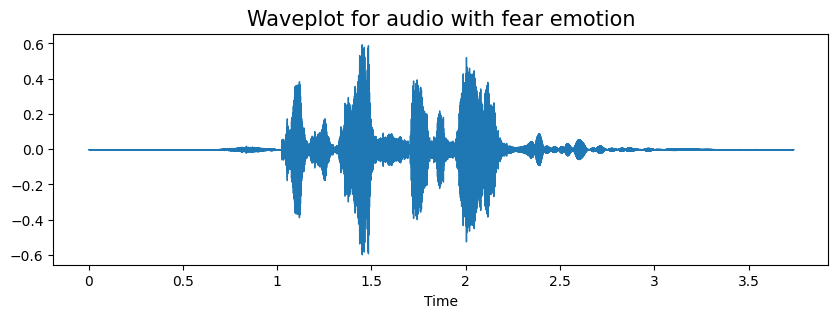

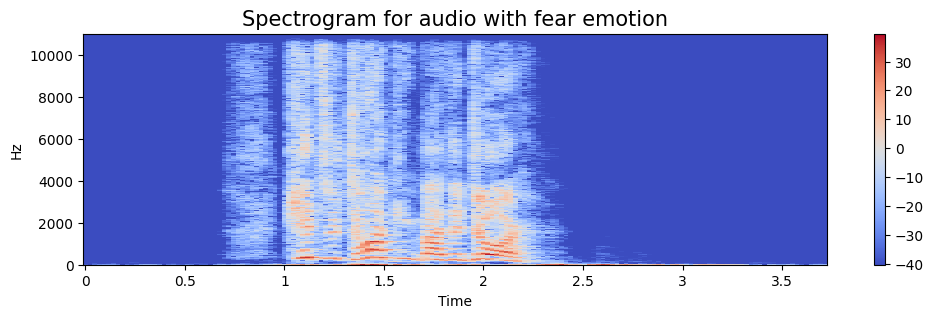

In [ ]:
emotion='fear'
path = np.array(RAV_df.path[RAV_df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
ipd.Audio(path)

**Data Augmentation**

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(RAV_df.path)[1]
data, sample_rate = librosa.load(path)

**Simple Audio**

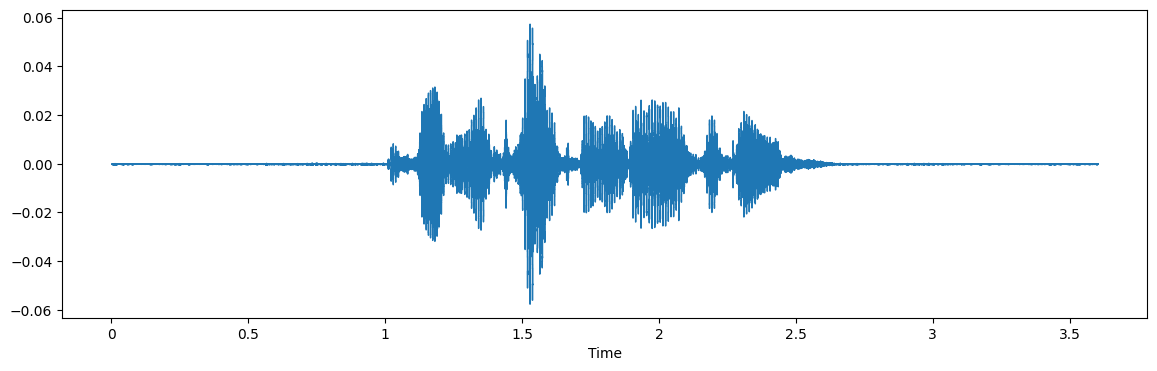

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
ipd.Audio(path)

 **Noise** **Injection**


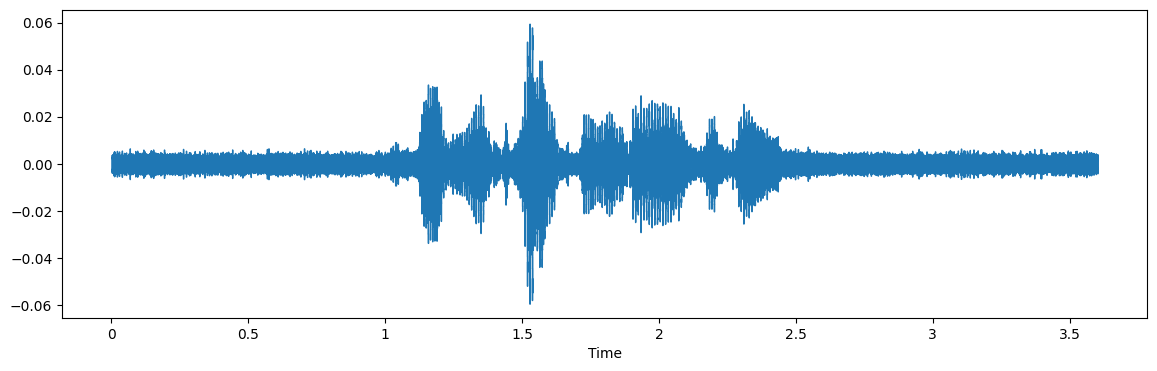

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

**Stretching**


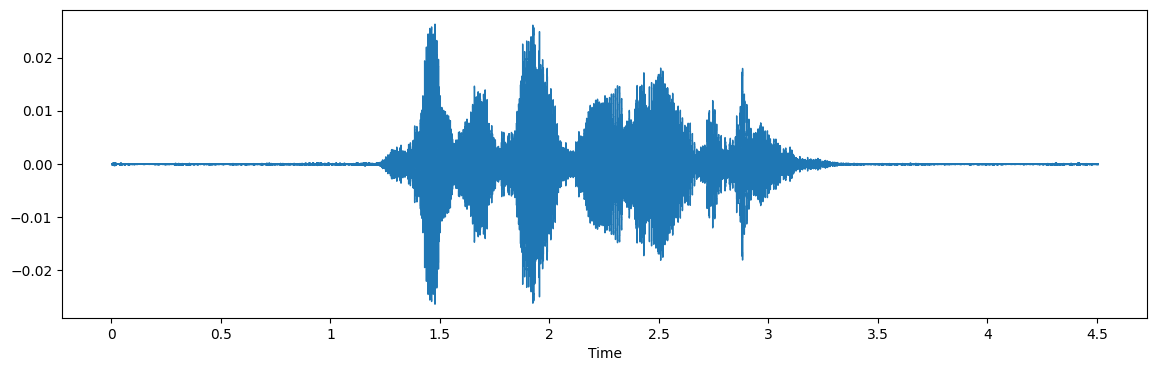

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

**Shifting**

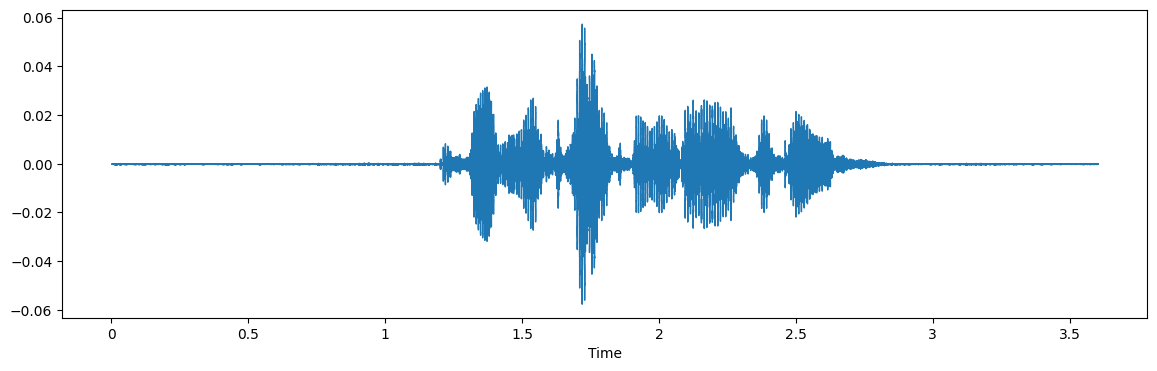

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

**Pitch**

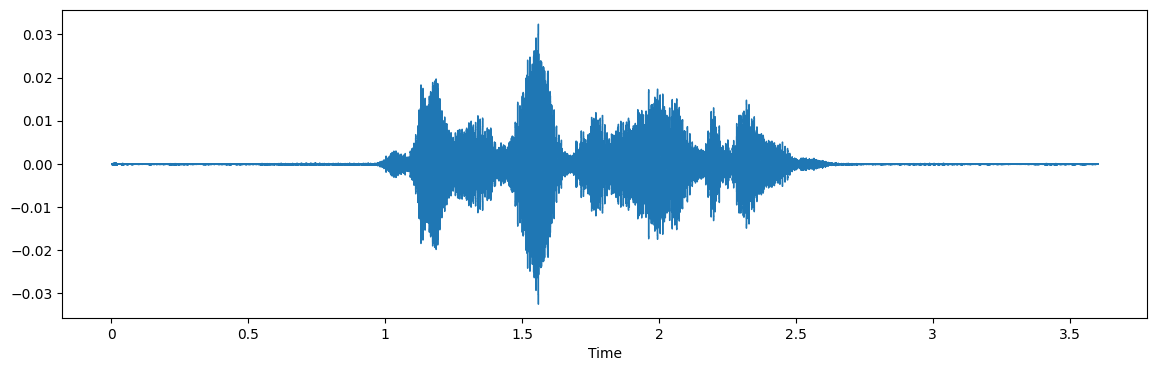

In [ ]:
x = pitch(data,sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

**Feature Extraction**

In [ ]:
# Feature extraction
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

**Data Preperation**

In [ ]:
X, Y = [], []
for path, emotion in zip(RAV_df.path, RAV_df.emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), RAV_df.path.shape


(4326, 4326, (1442,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

In [ ]:
display(Features.head())
display(Features.describe())

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.119701,0.586516,0.603775,0.634481,0.657241,0.672937,0.651460,0.599602,0.598464,0.623553,...,0.000458,0.000537,0.000766,0.000506,0.000458,0.000433,0.000394,0.000281,2.743974e-05,happy
1,0.239294,0.653576,0.660486,0.726068,0.737860,0.729617,0.631520,0.581802,0.611121,0.636547,...,0.000730,0.000830,0.001052,0.000798,0.000762,0.000767,0.000682,0.000602,3.433027e-04,happy
2,0.091045,0.574624,0.572103,0.573602,0.634806,0.647468,0.646268,0.616097,0.567680,0.614912,...,0.000075,0.000083,0.000106,0.000175,0.000169,0.000089,0.000103,0.000051,3.795275e-06,happy
3,0.109854,0.656128,0.657822,0.645414,0.664519,0.624621,0.616143,0.600568,0.706112,0.728587,...,0.000002,0.000004,0.000005,0.000009,0.000008,0.000008,0.000006,0.000003,2.719115e-07,neutral
4,0.177820,0.681936,0.687572,0.690137,0.732110,0.728215,0.677241,0.622316,0.707165,0.732648,...,0.000004,0.000005,0.000006,0.000010,0.000010,0.000009,0.000008,0.000005,1.492219e-06,neutral


,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
count,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,...,4.326000e+03,4.326000e+03,4.326000e+03,4.326000e+03,4.326000e+03,4.326000e+03,4.326000e+03,4.326000e+03,4.326000e+03,4.326000e+03
mean,0.211299,0.628186,0.631196,0.636193,0.646239,0.635731,0.607040,0.600767,0.619913,0.637513,...,1.748806e-03,1.762563e-03,1.801180e-03,1.833625e-03,1.884413e-03,1.917237e-03,1.915914e-03,1.878150e-03,1.379696e-03,7.489369e-04
std,0.069230,0.088148,0.097661,0.100638,0.102541,0.105438,0.091911,0.079066,0.080878,0.079631,...,6.113003e-03,6.177207e-03,6.273093e-03,6.399649e-03,6.670608e-03,6.706523e-03,6.583479e-03,6.325878e-03,5.265056e-03,4.259500e-03
min,0.060091,0.339261,0.287325,0.274444,0.261164,0.263645,0.269483,0.262952,0.242572,0.269638,...,2.135293e-08,1.692828e-08,2.129181e-08,2.400353e-08,2.899570e-08,2.325147e-08,6.041341e-08,7.742907e-08,3.496952e-08,2.159540e-09
25%,0.154971,0.568939,0.564962,0.565552,0.576092,0.565535,0.549860,0.553573,0.568581,0.586127,...,3.019007e-05,3.060564e-05,3.081483e-05,3.264484e-05,3.558043e-05,3.532357e-05,3.540089e-05,3.434309e-05,2.044105e-05,1.993408e-06
50%,0.201700,0.631480,0.635969,0.641229,0.652652,0.643071,0.615670,0.609762,0.626702,0.643998,...,1.677668e-04,1.664602e-04,1.691178e-04,1.819273e-04,1.850965e-04,1.837116e-04,1.870707e-04,1.845830e-04,1.143225e-04,1.498962e-05
75%,0.268117,0.691941,0.701707,0.710640,0.722532,0.711721,0.671376,0.656863,0.678062,0.694373,...,8.847851e-04,8.829780e-04,9.514376e-04,9.247928e-04,9.478127e-04,9.659969e-04,9.601225e-04,9.771273e-04,6.249443e-04,1.109046e-04
max,0.397479,0.863858,0.874752,0.890266,0.909878,0.901067,0.892185,0.813966,0.825857,0.868190,...,9.268925e-02,1.109993e-01,1.054221e-01,1.185149e-01,1.383819e-01,1.290368e-01,1.040207e-01,1.003996e-01,8.753475e-02,7.983964e-02


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3244, 162), (3244, 7), (1082, 162), (1082, 7))

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3244, 162), (3244, 7), (1082, 162), (1082, 7))

In [ ]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3244, 162, 1), (3244, 7), (1082, 162, 1), (1082, 7))

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 81, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 81, 128)           163968    
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 41, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 41, 64)            41024     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 21, 64)           

In [ ]:
Model: "sequential"


In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 3s 15ms/step - loss: 1.8637 - accuracy: 0.2312 - val_loss: 1.7987 - val_accuracy: 0.2736 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 0s 8ms/step - loss: 1.7983 - accuracy: 0.2836 - val_loss: 1.7649 - val_accuracy: 0.3105 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 0s 8ms/step - loss: 1.7623 - accuracy: 0.3009 - val_loss: 1.7134 - val_accuracy: 0.3226 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 0s 8ms/step - loss: 1.7166 - accuracy: 0.3252 - val_loss: 1.6369 - val_accuracy: 0.3475 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 0s 8ms/step - loss: 1.6710 - accuracy: 0.3391 - val_loss: 1.6034 - val_accuracy: 0.3567 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 0s 8ms/step - loss: 1.6419 - accuracy: 0.3468 - val_loss: 1.6006 - val_accuracy: 0.3641 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 0s 8ms/step - loss: 1.6126 - 

34/34 [==============================] - 0s 3ms/step - loss: 1.3848 - accuracy: 0.5767
Accuracy of our model on test data :  57.67098069190979 %


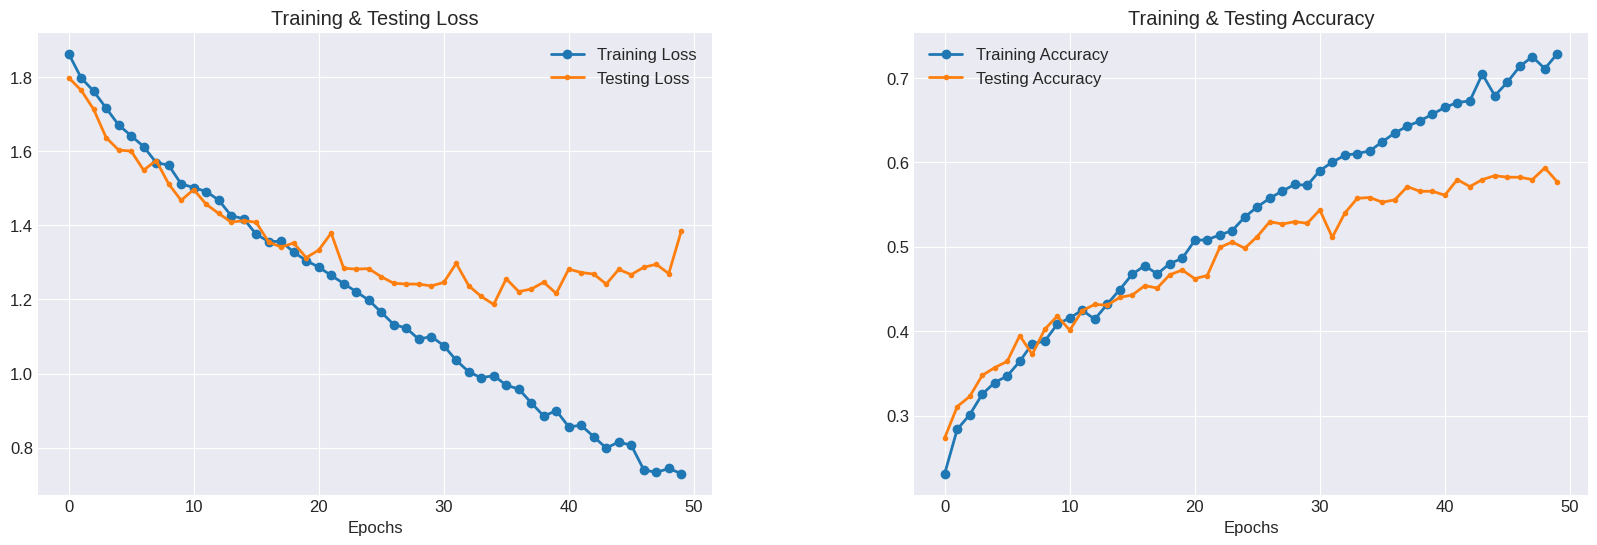

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 12})
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss',marker='o', linewidth=2)
ax[0].plot(epochs , test_loss , label = 'Testing Loss',marker='.', linewidth=2)
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy',marker='o', linewidth=2)
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy',marker='.', linewidth=2)
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.subplots_adjust(wspace=0.3)
plt.show()


In [ ]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 0s 2ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

display(df.head())

,Predicted Labels,Actual Labels
0,neutral,disgust
1,sad,happy
2,happy,surprise
3,sad,sad
4,neutral,neutral


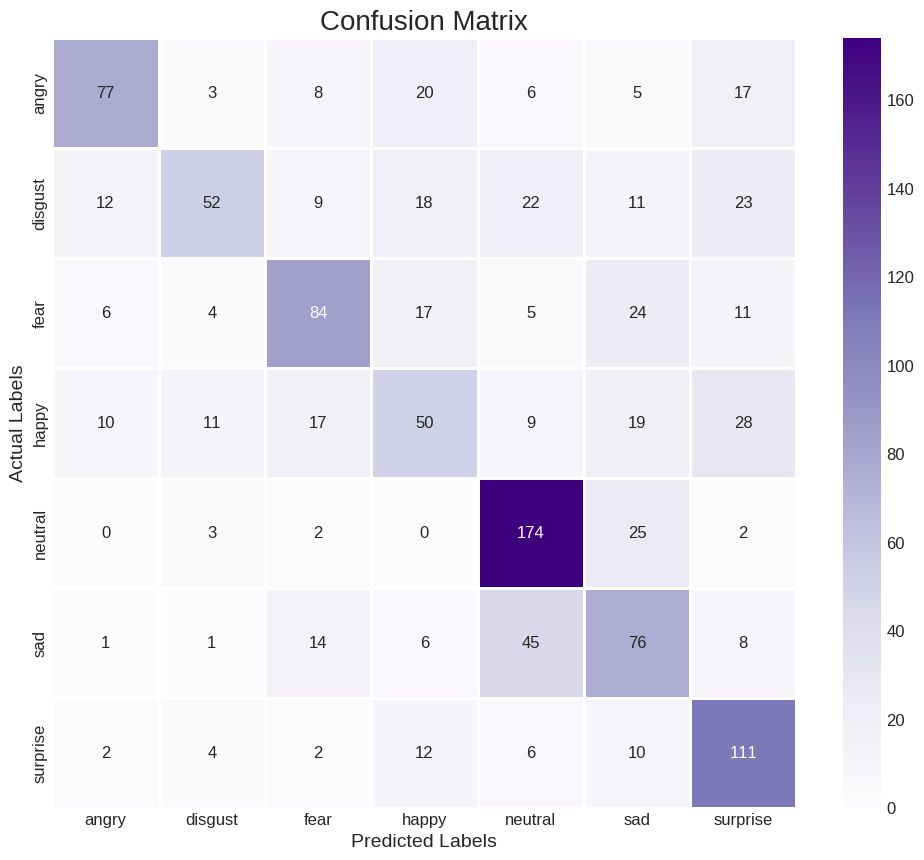

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       angry       0.71      0.57      0.63       136
     disgust       0.67      0.35      0.46       147
        fear       0.62      0.56      0.59       151
       happy       0.41      0.35      0.37       144
     neutral       0.65      0.84      0.74       206
         sad       0.45      0.50      0.47       151
    surprise       0.56      0.76      0.64       147

    accuracy                           0.58      1082
   macro avg       0.58      0.56      0.56      1082
weighted avg       0.58      0.58      0.57      1082

